In [172]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import ta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.datasets import load_diabetes

In [143]:
start = datetime.datetime(2009,1,1)
end = datetime.datetime(2022,1,21)

In [152]:
gold = yf.download('GC=F',interval='1d',start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [153]:
gold.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,881.500000,881.500000,868.900024,878.799988,878.799988,46
2009-01-05,882.000000,883.500000,847.000000,857.200012,857.200012,35
2009-01-06,855.099976,867.599976,840.000000,865.400024,865.400024,113
2009-01-07,862.000000,867.000000,837.700012,841.099976,841.099976,101
2009-01-08,837.900024,861.000000,837.900024,853.900024,853.900024,255


In [154]:
gold.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-13,1819.800049,1823.000000,1815.400024,1821.199951,1821.199951,40
2022-01-14,1821.500000,1822.000000,1816.500000,1816.500000,1816.500000,816
2022-01-18,1816.800049,1820.099976,1812.300049,1812.300049,1812.300049,900
2022-01-19,1817.400024,1843.099976,1817.400024,1843.099976,1843.099976,4
2022-01-20,1840.599976,1843.000000,1838.199951,1842.500000,1842.500000,4


### Drop Adj Close, since its the same as the Close price

In [155]:
gold.pop('Adj Close')

Date
2009-01-02     878.799988
2009-01-05     857.200012
2009-01-06     865.400024
2009-01-07     841.099976
2009-01-08     853.900024
                 ...     
2022-01-13    1821.199951
2022-01-14    1816.500000
2022-01-18    1812.300049
2022-01-19    1843.099976
2022-01-20    1842.500000
Name: Adj Close, Length: 3284, dtype: float64

In [156]:
gold.shape

(3284, 5)

In [157]:
gold.Close

Date
2009-01-02     878.799988
2009-01-05     857.200012
2009-01-06     865.400024
2009-01-07     841.099976
2009-01-08     853.900024
                 ...     
2022-01-13    1821.199951
2022-01-14    1816.500000
2022-01-18    1812.300049
2022-01-19    1843.099976
2022-01-20    1842.500000
Name: Close, Length: 3284, dtype: float64

In [158]:
dataframe = pd.DataFrame()
for i in range(1,10):
	gold['t-'+str(i)] = gold.Close.shift(i)

In [159]:
gold.head()

,Open,High,Low,Close,Volume,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9
Date,,,,,,,,,,,,,,
2009-01-02,881.500000,881.500000,868.900024,878.799988,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,882.000000,883.500000,847.000000,857.200012,35,878.799988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-06,855.099976,867.599976,840.000000,865.400024,113,857.200012,878.799988,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-07,862.000000,867.000000,837.700012,841.099976,101,865.400024,857.200012,878.799988,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-08,837.900024,861.000000,837.900024,853.900024,255,841.099976,865.400024,857.200012,878.799988,NaN,NaN,NaN,NaN,NaN


### Add some technical indicators

In [160]:
def get_sma(close,windows):
    df = pd.DataFrame()
    for window in windows:
        df['SMA_'+str(window)] = ta.trend.SMAIndicator(close,window).sma_indicator()
    return df

In [161]:
def get_atr(low,high,close,windows):
    df = pd.DataFrame()
    for window in windows:
        df['ATR_'+str(window)] = ta.volatility.AverageTrueRange(high,low,close,window).average_true_range()
    return df

In [162]:
def get_rsi(close,windows):
    df = pd.DataFrame()
    for window in windows:
        df['RSI_'+str(window)] = ta.momentum.RSIIndicator(close,window).rsi()
    return df

In [163]:
def get_mfi(low,high,close,volume,windows):
    df = pd.DataFrame()
    for window in windows:
        df['MFI_'+str(window)] = ta.volume.MFIIndicator(high,low,close,volume,window).money_flow_index()
    return df

In [164]:
windows = [15,30,45,60]

## Volume indicators
mfi_df = get_mfi(gold.Low,gold.High,gold.Close,gold.Volume,windows)
## Volatility indicators
atr_df = get_atr(gold.Low,gold.High,gold.Close,windows)
## Trend indicators
sma_df = get_sma(gold.Close,windows)
## Momentum indicators
rsi_df = get_rsi(gold.Close,windows)


gold = pd.concat([gold, sma_df,atr_df,rsi_df,mfi_df], axis=1)

In [165]:
gold.head()

,Open,High,Low,Close,Volume,t-1,t-2,t-3,t-4,t-5,...,ATR_45,ATR_60,RSI_15,RSI_30,RSI_45,RSI_60,MFI_15,MFI_30,MFI_45,MFI_60
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-02,881.500000,881.500000,868.900024,878.799988,46,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,882.000000,883.500000,847.000000,857.200012,35,878.799988,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-06,855.099976,867.599976,840.000000,865.400024,113,857.200012,878.799988,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-07,862.000000,867.000000,837.700012,841.099976,101,865.400024,857.200012,878.799988,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-08,837.900024,861.000000,837.900024,853.900024,255,841.099976,865.400024,857.200012,878.799988,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
gold.columns.shape

(30,)

In [167]:
gold = gold.dropna()

In [168]:
gold

,Open,High,Low,Close,Volume,t-1,t-2,t-3,t-4,t-5,...,ATR_45,ATR_60,RSI_15,RSI_30,RSI_45,RSI_60,MFI_15,MFI_30,MFI_45,MFI_60
Date,,,,,,,,,,,,,,,,,,,,,
2009-03-30,924.599976,932.500000,908.599976,915.500000,58837,923.000000,939.599976,935.400024,923.299988,952.099976,...,23.935809,23.999995,47.120391,49.786519,50.679246,51.091376,0.572473,2.703323,21.053536,21.148793
2009-03-31,918.000000,924.500000,911.599976,922.599976,7403,915.500000,923.000000,939.599976,935.400024,923.299988,...,23.690569,23.814995,48.835430,50.698793,51.380363,51.699295,4.748687,5.736882,22.506821,22.600503
2009-04-01,918.599976,932.500000,916.900024,926.099976,3659,922.599976,915.500000,923.000000,939.599976,935.400024,...,23.510778,23.678078,49.697123,51.151369,51.726336,51.998401,6.584296,7.377043,23.214122,23.304559
2009-04-02,926.900024,930.299988,894.900024,907.400024,3389,926.099976,922.599976,915.500000,923.000000,939.599976,...,23.774983,23.873443,45.327160,48.681392,49.790326,50.305770,6.403238,7.140684,34.110963,23.119290
2009-04-03,904.599976,910.299988,891.299988,895.599976,1616,907.400024,926.099976,922.599976,915.500000,923.000000,...,23.668872,23.792219,42.783664,47.193788,48.616027,49.276441,6.312978,6.966042,13.693503,23.035553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-13,1819.800049,1823.000000,1815.400024,1821.199951,40,1827.199951,1818.599976,1798.400024,1797.000000,1788.699951,...,17.405805,17.707639,55.001040,53.068251,52.202325,51.664444,82.400029,67.075215,3.918505,5.106852
2022-01-14,1821.500000,1822.000000,1816.500000,1816.500000,816,1821.199951,1827.199951,1818.599976,1798.400024,1797.000000,...,17.141232,17.504179,53.480326,52.339150,51.723800,51.309963,68.768475,71.015444,3.779958,5.031406
2022-01-18,1816.800049,1820.099976,1812.300049,1812.300049,900,1816.500000,1821.199951,1827.199951,1818.599976,1798.400024,...,16.933647,17.342441,52.101092,51.682744,51.294072,50.992017,57.563950,64.112997,3.768778,4.800508


[3.06089845e-03 2.63072074e-01 7.25225619e-01 1.84813949e-05
 3.94067061e-03 5.59826901e-05 1.37471157e-04 1.44316449e-05
 1.41672102e-05 1.43151592e-05 1.64525708e-05 1.35309433e-05
 1.47660798e-05 7.88456514e-04 1.03220643e-03 1.04168590e-03
 1.19603073e-03 1.96830510e-05 1.48156826e-05 1.22130547e-05
 1.36276111e-05 4.23576049e-05 4.19574517e-05 3.23629847e-05
 1.03427142e-04 1.81946726e-05 1.56232199e-05 1.38987664e-05
 1.45975950e-05]


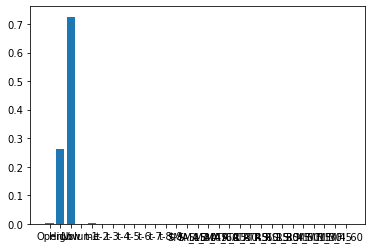

In [169]:
# split into input and output
X = gold.drop(columns=['Close'])
y = gold.Close
# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X, y)
# show importance scores
print(model.feature_importances_)
# plot importance scores
names = X.columns
ticks = [i for i in range(len(names))]
plt.bar(ticks, model.feature_importances_)
plt.xticks(ticks, names)
plt.show()

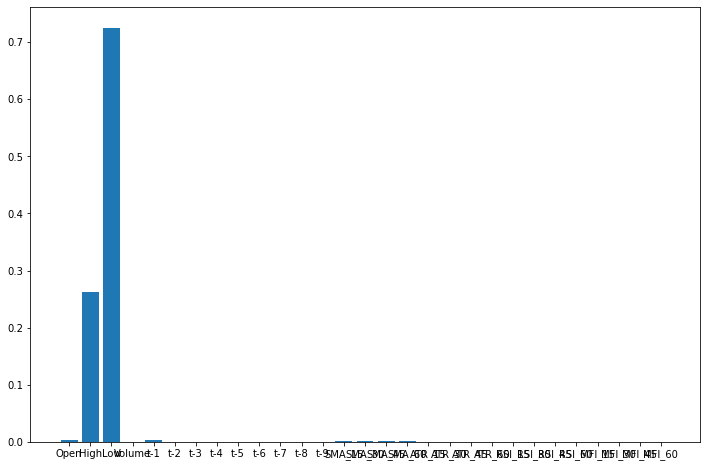

In [170]:
plt.figure(figsize=(12,8))
plt.bar(ticks, model.feature_importances_)
plt.xticks(ticks, names)
plt.show()

In [192]:
fs_rf = names[model.feature_importances_ > 0.001]

In [140]:
gold.head()

,Open,High,Low,Close,Volume,SMA_15,SMA_30,SMA_45,SMA_60,ATR_15,...,ATR_45,ATR_60,RSI_15,RSI_30,RSI_45,RSI_60,MFI_15,MFI_30,MFI_45,MFI_60
Date,,,,,,,,,,,,,,,,,,,,,
2009-03-30,924.599976,932.500000,908.599976,915.500000,58837,925.946663,938.973330,930.335552,909.468330,23.992311,...,23.935809,23.999995,47.120391,49.786519,50.679246,51.091376,0.572473,2.703323,21.053536,21.148793
2009-03-31,918.000000,924.500000,911.599976,922.599976,7403,927.746663,937.493329,930.648885,910.198330,23.252825,...,23.690569,23.814995,48.835430,50.698793,51.380363,51.699295,4.748687,5.736882,22.506821,22.600503
2009-04-01,918.599976,932.500000,916.900024,926.099976,3659,928.793327,935.773328,931.246662,911.346662,22.742635,...,23.510778,23.678078,49.697123,51.151369,51.726336,51.998401,6.584296,7.377043,23.214122,23.304559
2009-04-02,926.900024,930.299988,894.900024,907.400024,3389,927.706661,933.483329,931.675552,912.046662,23.586457,...,23.774983,23.873443,45.327160,48.681392,49.790326,50.305770,6.403238,7.140684,34.110963,23.119290
2009-04-03,904.599976,910.299988,891.299988,895.599976,1616,925.426660,929.943329,931.464441,912.954996,23.280693,...,23.668872,23.792219,42.783664,47.193788,48.616027,49.276441,6.312978,6.966042,13.693503,23.035553


In [178]:
X = gold.drop(columns=['Close'])
y = gold.Close
features = X.columns
pipeline = Pipeline([
                     ('scaler',MinMaxScaler()),
                     ('model',Lasso(tol=0.01))
])
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

search.fit(X,y)
search.best_params_
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ...............................model__alpha=0.1; total time=   0.0s
[CV 2/5] END ...............................model__alpha=0.1; total time=   0.0s
[CV 3/5] END ...............................model__alpha=0.1; total time=   0.0s
[CV 4/5] END ...............................model__alpha=0.1; total time=   0.0s
[CV 5/5] END ...............................model__alpha=0.1; total time=   0.0s
[CV 1/5] END ...............................model__alpha=0.2; total time=   0.0s
[CV 2/5] END ...............................model__alpha=0.2; total time=   0.0s
[CV 3/5] END ...............................model__alpha=0.2; total time=   0.0s
[CV 4/5] END ...............................model__alpha=0.2; total time=   0.0s
[CV 5/5] END ...............................model__alpha=0.2; total time=   0.0s
[CV 1/5] END ...............model__alpha=0.30000000000000004; total time=   0.0s
[CV 2/5] END ...............model__alpha=0.3000

In [189]:
fs_lass = np.array(features)[importance > 0]

In [181]:
coefficients = np.abs(search.best_estimator_.named_steps['model'].coef_)


<BarContainer object of 29 artists>

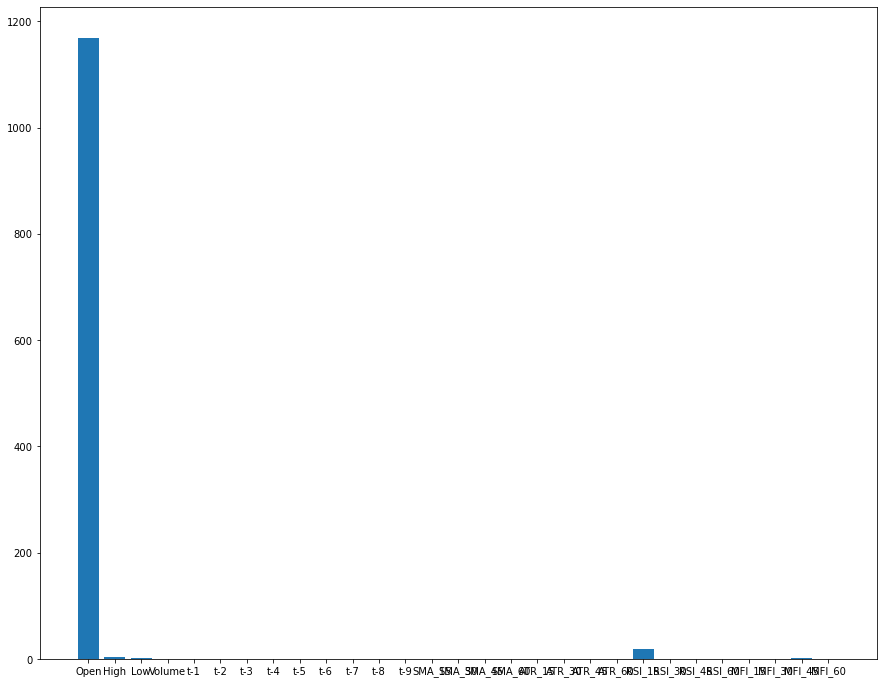

In [187]:
plt.figure(figsize=(15,12))
plt.bar(features,coefficients)

In [193]:
fs_lass

array(['Open', 'High', 'Low', 'SMA_30', 'SMA_45', 'SMA_60', 'RSI_15',
       'MFI_15', 'MFI_45', 'MFI_60'], dtype=object)

In [194]:
fs_rf

Index(['Open', 'High', 'Low', 't-1', 'SMA_30', 'SMA_45', 'SMA_60'], dtype='object')

In [196]:
selected_features = np.intersect1d(fs_rf,fs_lass)

In [211]:
final_data = gold[selected_features].copy()

In [212]:
final_data.head()

,High,Low,Open,SMA_30,SMA_45,SMA_60
Date,,,,,,
2009-03-30,932.500000,908.599976,924.599976,938.973330,930.335552,909.468330
2009-03-31,924.500000,911.599976,918.000000,937.493329,930.648885,910.198330
2009-04-01,932.500000,916.900024,918.599976,935.773328,931.246662,911.346662
2009-04-02,930.299988,894.900024,926.900024,933.483329,931.675552,912.046662
2009-04-03,910.299988,891.299988,904.599976,929.943329,931.464441,912.954996


In [221]:
final_data['Close'] = gold.Close

In [222]:
final_data

,High,Low,Open,SMA_30,SMA_45,SMA_60,Close
Date,,,,,,,
2009-03-30,932.500000,908.599976,924.599976,938.973330,930.335552,909.468330,915.500000
2009-03-31,924.500000,911.599976,918.000000,937.493329,930.648885,910.198330,922.599976
2009-04-01,932.500000,916.900024,918.599976,935.773328,931.246662,911.346662,926.099976
2009-04-02,930.299988,894.900024,926.900024,933.483329,931.675552,912.046662,907.400024
2009-04-03,910.299988,891.299988,904.599976,929.943329,931.464441,912.954996,895.599976
...,...,...,...,...,...,...,...
2022-01-13,1823.000000,1815.400024,1819.800049,1797.016654,1805.133322,1804.181655,1821.199951
2022-01-14,1822.000000,1816.500000,1821.500000,1798.876656,1804.095546,1804.769989,1816.500000
2022-01-18,1820.099976,1812.300049,1816.800049,1799.886658,1802.859991,1805.049990,1812.300049


In [299]:
def get_training_test(data,window_size):
    X,Y = [],[]
    for i in range(0,len(data)-window_size):
        X.append(data.iloc[i:i+window_size,:].T.to_numpy().flatten())
        Y.append(data.Close[i+window_size])
    return np.array(X),np.array(Y)

In [300]:
final_data.head(6)

,High,Low,Open,SMA_30,SMA_45,SMA_60,Close
Date,,,,,,,
2009-03-30,932.500000,908.599976,924.599976,938.973330,930.335552,909.468330,915.500000
2009-03-31,924.500000,911.599976,918.000000,937.493329,930.648885,910.198330,922.599976
2009-04-01,932.500000,916.900024,918.599976,935.773328,931.246662,911.346662,926.099976
2009-04-02,930.299988,894.900024,926.900024,933.483329,931.675552,912.046662,907.400024
2009-04-03,910.299988,891.299988,904.599976,929.943329,931.464441,912.954996,895.599976
2009-04-06,895.000000,865.099976,895.000000,925.839996,930.224441,913.248329,871.500000


In [301]:
x,y = get_training_test(final_data,5)

In [302]:
final_data.tail()

,High,Low,Open,SMA_30,SMA_45,SMA_60,Close
Date,,,,,,,
2022-01-13,1823.000000,1815.400024,1819.800049,1797.016654,1805.133322,1804.181655,1821.199951
2022-01-14,1822.000000,1816.500000,1821.500000,1798.876656,1804.095546,1804.769989,1816.500000
2022-01-18,1820.099976,1812.300049,1816.800049,1799.886658,1802.859991,1805.049990,1812.300049
2022-01-19,1843.099976,1817.400024,1817.400024,1802.073324,1802.348880,1805.668323,1843.099976
2022-01-20,1843.000000,1838.199951,1840.599976,1804.069991,1802.102214,1806.498324,1842.500000


### Models

dtype('float64')